<a href="https://colab.research.google.com/github/renatampr/https-github.com-renatampr-topicos_contemporaneos--CESAR-EAD-2024/blob/main/RENATA_10_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Grupo:
Renata Pereira rmbp@cesar.school

Daniel Moraes - dmms@cesar.school

Fabio Mesel - fom@cesar.school

In [ ]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

mkdir: cannot create directory ‘data/’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  2699k      0  0:00:04  0:00:04 --:--:-- 2885k
Archive:  data/animais.zip
replace data/animais/val/tatu/10242.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_aug)


train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 13/13 [01:36<00:00,  7.45s/it]


Epoch 1, Train Loss: 0.707, Train Accuracy: 47.75%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.693, Val Accuracy: 46.72%


100%|██████████| 13/13 [01:32<00:00,  7.08s/it]


Epoch 2, Train Loss: 0.689, Train Accuracy: 55.00%
Epoch 2, Val Loss: 0.675, Val Accuracy: 57.38%


100%|██████████| 13/13 [01:33<00:00,  7.19s/it]


Epoch 3, Train Loss: 0.690, Train Accuracy: 54.75%
Epoch 3, Val Loss: 0.665, Val Accuracy: 54.92%


100%|██████████| 13/13 [01:32<00:00,  7.13s/it]


Epoch 4, Train Loss: 0.724, Train Accuracy: 51.75%
Epoch 4, Val Loss: 0.675, Val Accuracy: 57.38%


100%|██████████| 13/13 [01:40<00:00,  7.71s/it]


Epoch 5, Train Loss: 0.699, Train Accuracy: 53.75%
Epoch 5, Val Loss: 0.707, Val Accuracy: 54.10%
Treinamento concluído


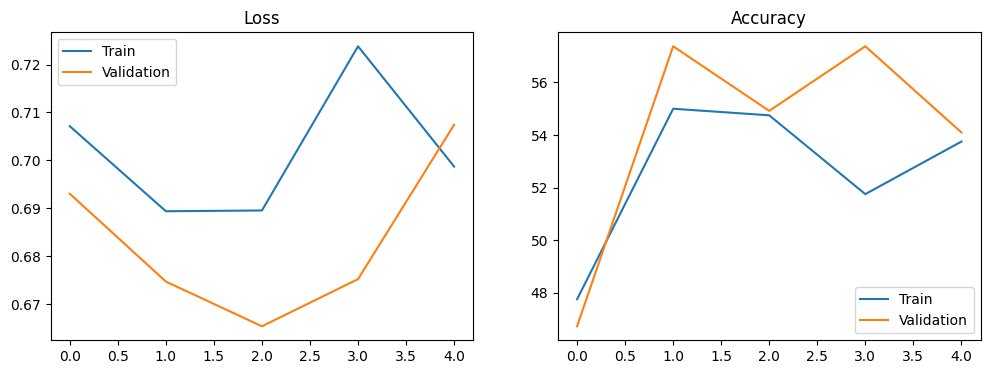

Acurácia da rede na base de teste: 54.10%


In [ ]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [ ]:
# Utilizando pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

100%|██████████| 13/13 [00:32<00:00,  2.49s/it]


Epoch 1, Train Loss: 0.635, Train Accuracy: 62.50%
Epoch 1, Val Loss: 0.468, Val Accuracy: 79.51%


100%|██████████| 13/13 [00:33<00:00,  2.57s/it]


Epoch 2, Train Loss: 0.402, Train Accuracy: 86.25%
Epoch 2, Val Loss: 0.373, Val Accuracy: 86.07%


100%|██████████| 13/13 [00:33<00:00,  2.55s/it]


Epoch 3, Train Loss: 0.306, Train Accuracy: 89.25%
Epoch 3, Val Loss: 0.267, Val Accuracy: 90.98%


100%|██████████| 13/13 [00:32<00:00,  2.52s/it]


Epoch 4, Train Loss: 0.272, Train Accuracy: 88.50%
Epoch 4, Val Loss: 0.257, Val Accuracy: 90.16%


100%|██████████| 13/13 [00:32<00:00,  2.54s/it]


Epoch 5, Train Loss: 0.277, Train Accuracy: 89.75%
Epoch 5, Val Loss: 0.250, Val Accuracy: 90.98%
Treinamento concluído


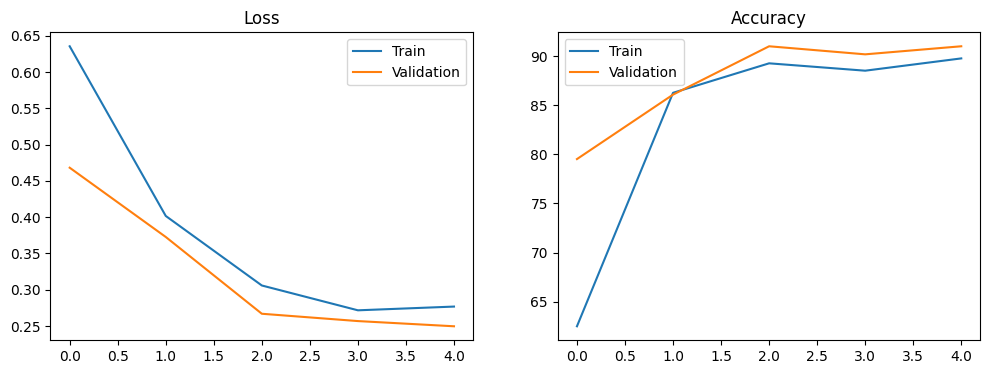

Acurácia da rede na base de teste: 91.80%


In [ ]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [ ]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

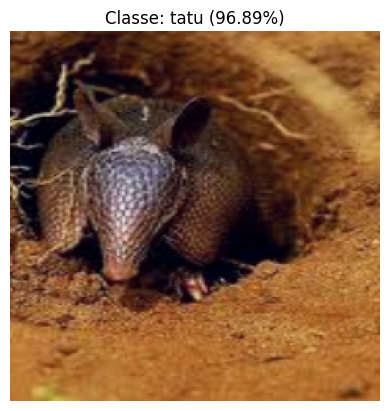

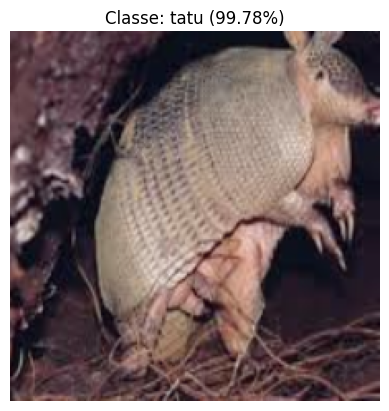

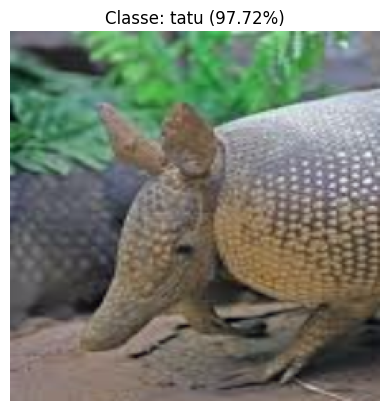

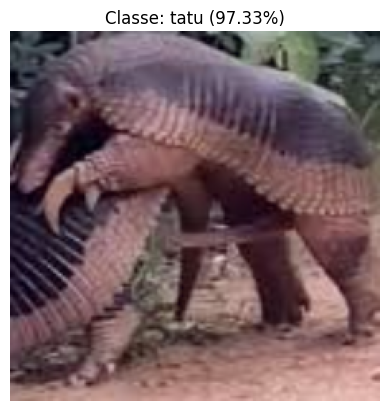

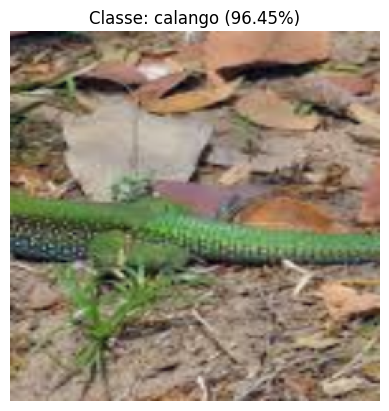

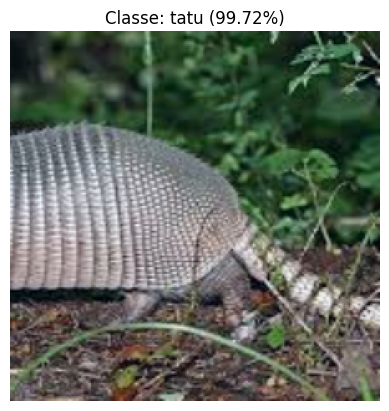

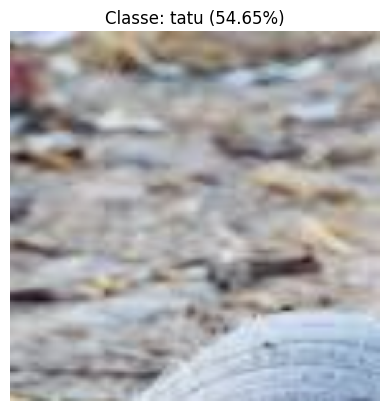

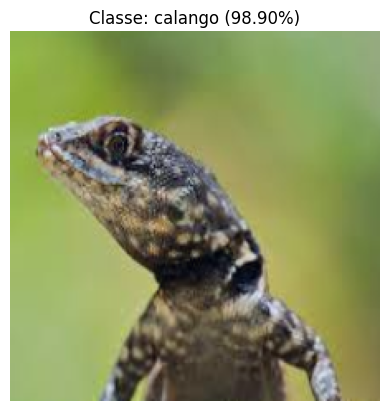

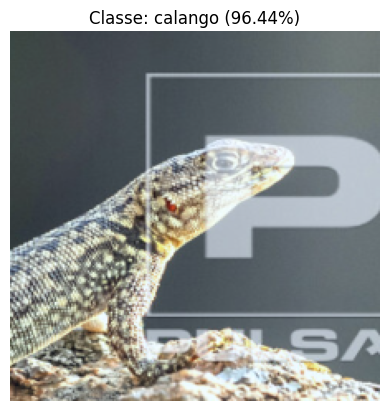

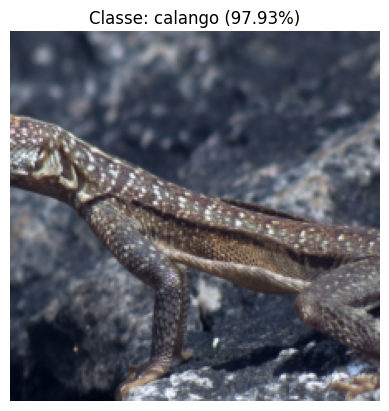

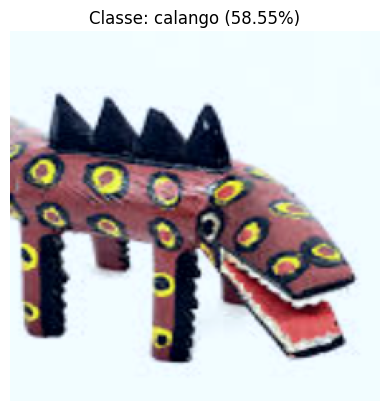

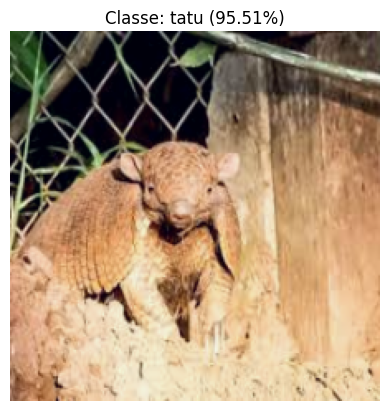

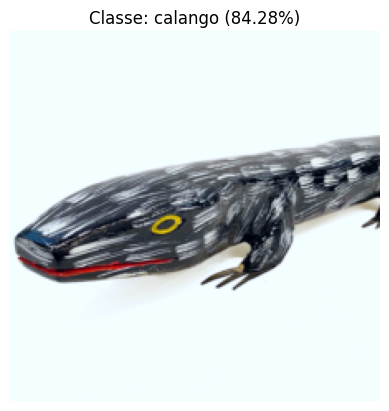

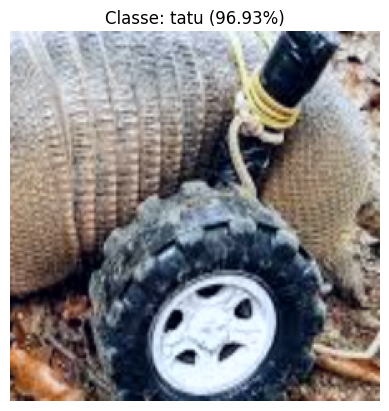

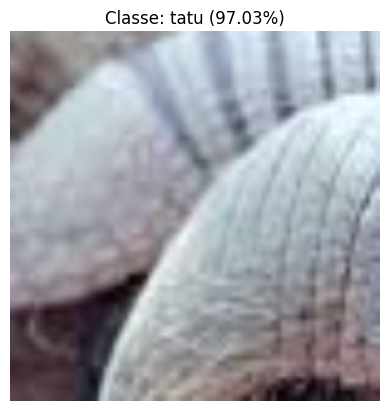

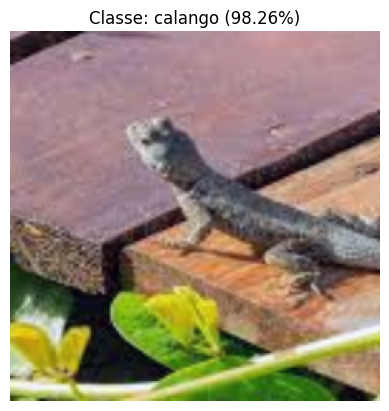

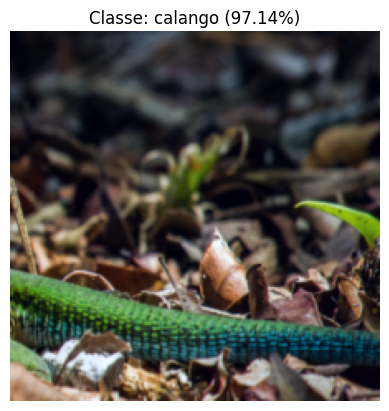

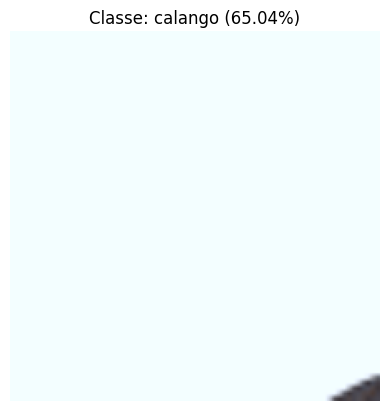

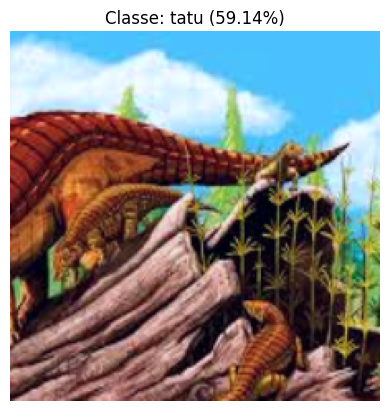

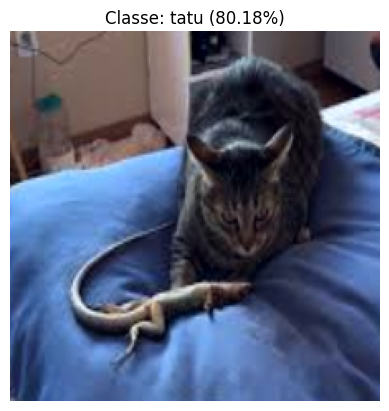

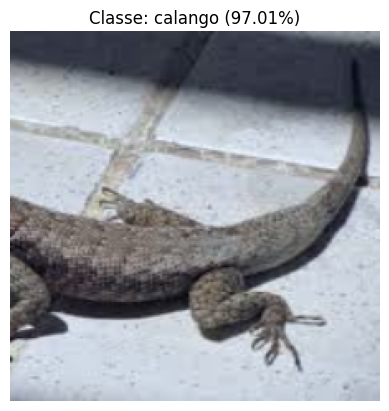

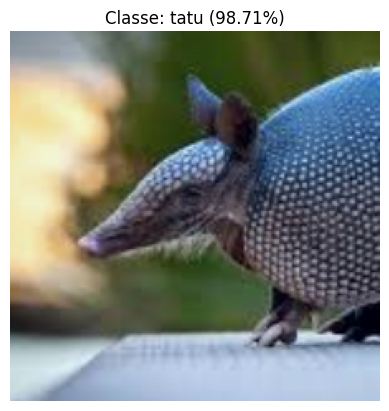

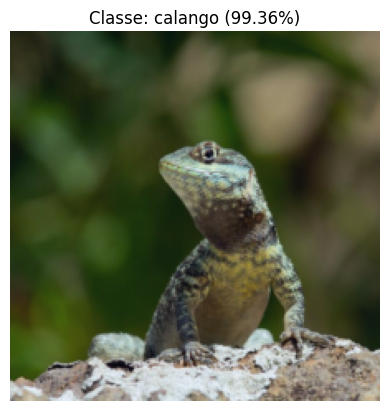

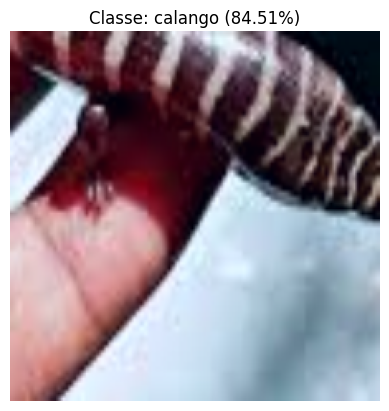

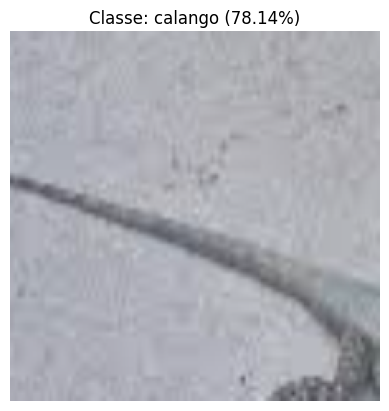

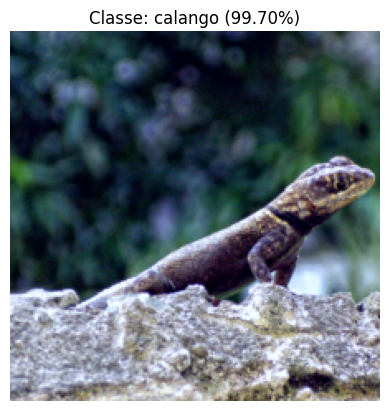

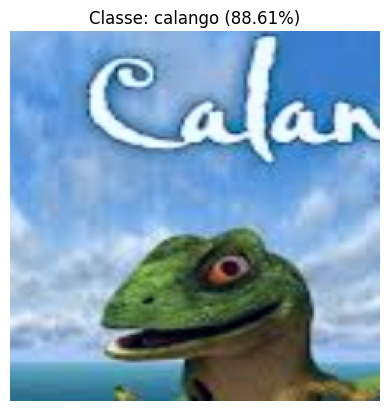

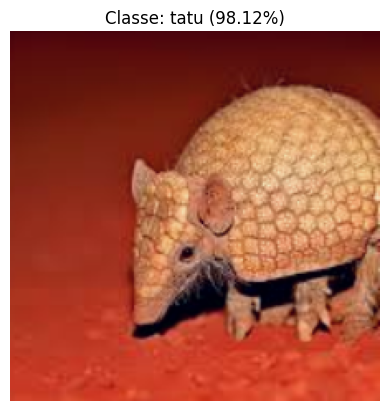

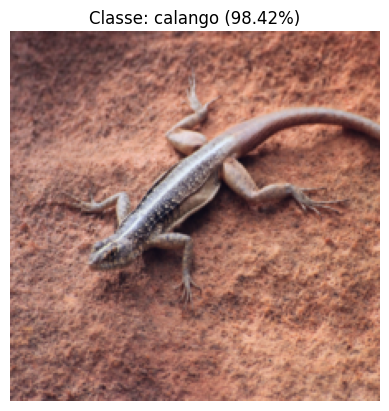

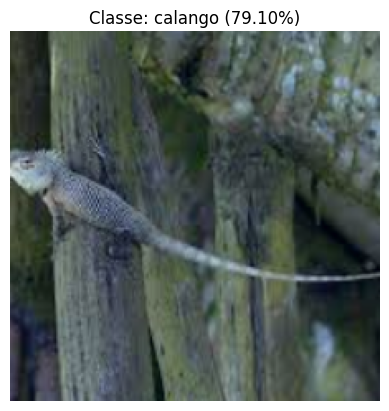

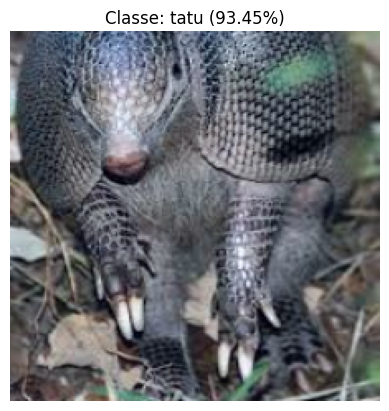

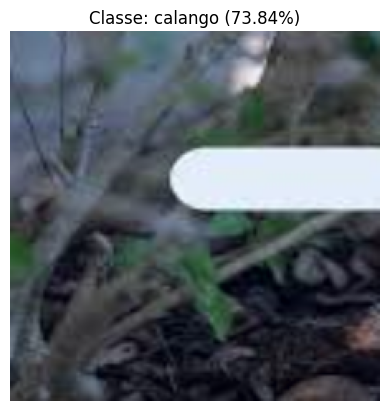

In [ ]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

In [ ]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"
train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
#train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
#train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 13/13 [01:32<00:00,  7.09s/it]


Epoch 1, Train Loss: 3.455, Train Accuracy: 39.00%
Epoch 1, Val Loss: 1.973, Val Accuracy: 53.28%


100%|██████████| 13/13 [01:31<00:00,  7.02s/it]


Epoch 2, Train Loss: 0.704, Train Accuracy: 51.75%
Epoch 2, Val Loss: 0.710, Val Accuracy: 57.38%


100%|██████████| 13/13 [01:33<00:00,  7.18s/it]


Epoch 3, Train Loss: 0.716, Train Accuracy: 51.25%
Epoch 3, Val Loss: 0.677, Val Accuracy: 57.38%


100%|██████████| 13/13 [01:32<00:00,  7.12s/it]


Epoch 4, Train Loss: 0.687, Train Accuracy: 55.50%
Epoch 4, Val Loss: 0.725, Val Accuracy: 47.54%


100%|██████████| 13/13 [01:30<00:00,  6.97s/it]


Epoch 5, Train Loss: 0.658, Train Accuracy: 58.00%
Epoch 5, Val Loss: 0.831, Val Accuracy: 43.44%
Treinamento concluído


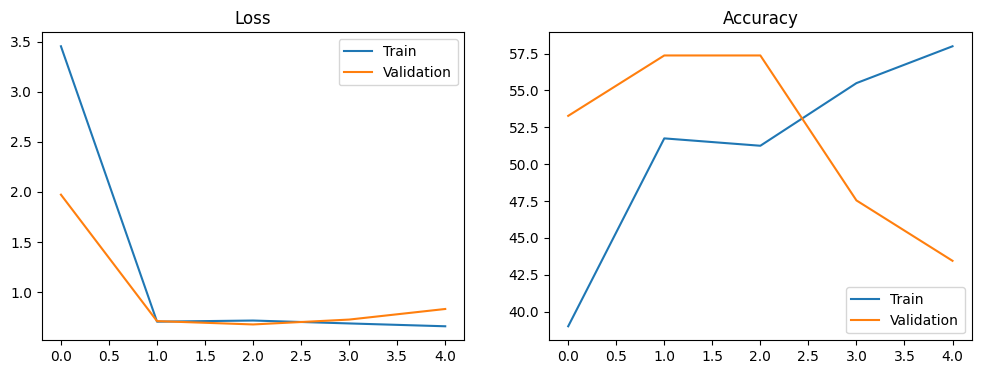

Acurácia da rede na base de teste: 43.44%


In [ ]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, device, num_epochs=5)

#history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = True

In [ ]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

100%|██████████| 13/13 [01:31<00:00,  7.03s/it]


Epoch 1, Train Loss: 0.700, Train Accuracy: 52.50%
Epoch 1, Val Loss: 0.682, Val Accuracy: 55.74%


100%|██████████| 13/13 [01:31<00:00,  7.03s/it]


Epoch 2, Train Loss: 0.675, Train Accuracy: 58.75%
Epoch 2, Val Loss: 0.738, Val Accuracy: 56.56%


100%|██████████| 13/13 [01:31<00:00,  7.05s/it]


Epoch 3, Train Loss: 0.691, Train Accuracy: 55.50%
Epoch 3, Val Loss: 0.675, Val Accuracy: 59.02%


100%|██████████| 13/13 [01:31<00:00,  7.06s/it]


Epoch 4, Train Loss: 0.661, Train Accuracy: 60.25%
Epoch 4, Val Loss: 0.742, Val Accuracy: 50.82%


100%|██████████| 13/13 [01:29<00:00,  6.91s/it]


Epoch 5, Train Loss: 0.651, Train Accuracy: 62.75%
Epoch 5, Val Loss: 0.658, Val Accuracy: 59.84%
Treinamento concluído


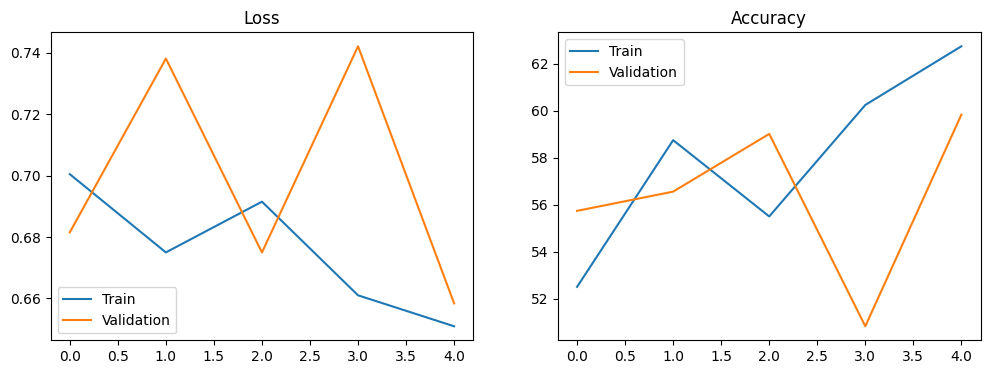

Acurácia da rede na base de teste: 59.84%


In [ ]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [ ]:
# Utilizando pesos pré-treinados
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.0MB/s]


In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)

100%|██████████| 13/13 [03:50<00:00, 17.71s/it]


Epoch 1, Train Loss: 0.445, Train Accuracy: 78.00%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.159, Val Accuracy: 95.08%


100%|██████████| 13/13 [03:43<00:00, 17.20s/it]


Epoch 2, Train Loss: 0.239, Train Accuracy: 89.25%
Epoch 2, Val Loss: 0.128, Val Accuracy: 94.26%


100%|██████████| 13/13 [03:52<00:00, 17.90s/it]


Epoch 3, Train Loss: 0.184, Train Accuracy: 93.25%
Epoch 3, Val Loss: 0.110, Val Accuracy: 95.08%


100%|██████████| 13/13 [03:46<00:00, 17.39s/it]


Epoch 4, Train Loss: 0.215, Train Accuracy: 92.50%
Epoch 4, Val Loss: 0.112, Val Accuracy: 95.08%


100%|██████████| 13/13 [03:59<00:00, 18.40s/it]


Epoch 5, Train Loss: 0.221, Train Accuracy: 91.25%
Epoch 5, Val Loss: 0.125, Val Accuracy: 93.44%
Treinamento concluído


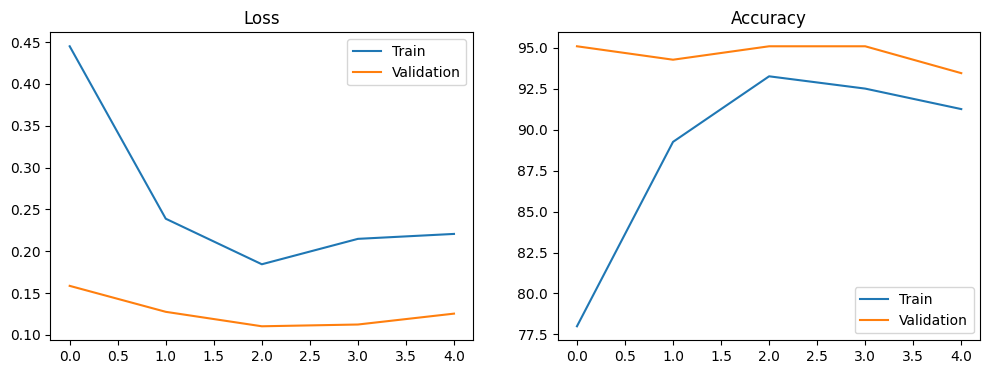

Acurácia da rede na base de teste: 93.44%


In [ ]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)